# Generalization

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


plt.style.use("seaborn-v0_8-whitegrid")

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## Validation Set Approach

In [14]:
# helper function to simulate data
def gen_validation_data(seed):
    np.random.seed(seed)
    n = 50
    X = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n, 1))
    y = np.sin(X).ravel() + np.random.normal(loc=0, scale=0.25, size=n)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.20)
    X_vtrain, X_validation, y_vtrain, y_validation = train_test_split(
        X_train, y_train, test_size=0.20, random_state=seed
    )
    return X_train, y_train, X_vtrain, X_validation, y_vtrain, y_validation

In [15]:
# here we define the values of k we will consider
k_values = np.arange(1, 11)

In [16]:
# calculate validation RMSE and find best k
# do this for 100 simulated datasets
k_best = []
for seed in range(100):
    k_rmse = []
    # only need vtrain and validation
    _, _, X_vtrain, X_validation, y_vtrain, y_validation = gen_validation_data(seed)
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_vtrain, y_vtrain)
        k_rmse.append(rmse(y_validation, knn.predict(X_validation)))
    k_best.append(k_rmse.index(min(k_rmse)) + 1)

In [17]:
np.array(k_best)

array([ 1,  6,  2,  5,  1,  7,  1,  7,  1,  2,  3, 10,  1,  4,  1,  2,  1,
        5,  9,  2,  3,  4,  2,  2,  7,  4,  1,  3,  5,  3,  2,  8,  3,  3,
        3,  2,  2,  3,  2,  1,  2,  5,  6,  2,  2,  2,  2,  1,  2,  4,  1,
        2,  6,  1,  1,  8,  6,  4,  2,  1,  2,  3,  1,  4,  2,  2,  2,  4,
        1,  1,  3,  3,  8,  4,  9,  7,  6,  3,  7,  3,  5,  2,  5,  4,  1,
        4,  1,  1,  1,  4,  3,  6,  1,  1,  5,  1,  1,  1,  4,  3])

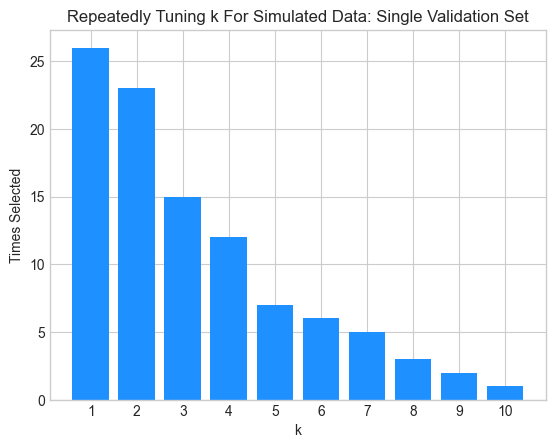

In [18]:
fig, ax = plt.subplots()

ax.bar(k_values, [k_best.count(i) for i in k_values], color="dodgerblue")
ax.set_title("Repeatedly Tuning k For Simulated Data: Single Validation Set")
ax.set_xlabel("k")
ax.set_ylabel("Times Selected")
ax.set_xticks(k_values)

plt.show()

## Cross-Validation

In [19]:
np.random.seed(42)
n = 25
X_train = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n, 1))
y_train = np.sin(X_train).ravel() + np.random.normal(loc=0, scale=0.25, size=n)

kf = KFold(n_splits=5, shuffle=True)
knn = KNeighborsRegressor(n_neighbors=3)

rmse_folds = []

# note: we do not recommend performing cross-validation like this in practice
# this is done here for illustrative purposes
# this shows which observations are using for training or validation in each fold
for i, (vtrain_index, validation_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Validation-Train: index={vtrain_index}")
    print(f"  Validation:  index={validation_index}")
    knn.fit(X_train[vtrain_index, :], y_train[vtrain_index])
    predictions = knn.predict(X_train[validation_index, :])
    rmse_fold = rmse(y_train[validation_index], predictions)
    print(f"  Validation RMSE for fold {i}: {np.round(rmse_fold, 3)}.")
    print(f"")
    rmse_folds.append(rmse_fold)

print(rmse_folds)
print(np.mean(rmse_fold))

Fold 0:
  Validation-Train: index=[ 0  2  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24]
  Validation:  index=[ 1  3  4  5 18]
  Validation RMSE for fold 0: 0.432.

Fold 1:
  Validation-Train: index=[ 0  1  2  3  4  5  6  7  8 10 11 12 14 16 18 19 21 22 23 24]
  Validation:  index=[ 9 13 15 17 20]
  Validation RMSE for fold 1: 0.328.

Fold 2:
  Validation-Train: index=[ 0  1  3  4  5  6  8  9 11 12 13 14 15 17 18 19 20 22 23 24]
  Validation:  index=[ 2  7 10 16 21]
  Validation RMSE for fold 2: 0.511.

Fold 3:
  Validation-Train: index=[ 1  2  3  4  5  7  8  9 10 12 13 14 15 16 17 18 20 21 23 24]
  Validation:  index=[ 0  6 11 19 22]
  Validation RMSE for fold 3: 0.301.

Fold 4:
  Validation-Train: index=[ 0  1  2  3  4  5  6  7  9 10 11 13 15 16 17 18 19 20 21 22]
  Validation:  index=[ 8 12 14 23 24]
  Validation RMSE for fold 4: 0.508.

[0.43220315897900297, 0.32825785809603286, 0.5114604124701475, 0.30141545242796486, 0.5084837968940963]
0.5084837968940963


### Tuning with Cross-Validation

In [20]:
k_best = []
for seed in range(100):
    # here we only need the full train data
    # cross-validation will auto-magically create vtrain and validation for each fold
    X_train, y_train, _, _, _, _ = gen_validation_data(seed)
    k_rmse = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
        rmse_scores = np.sqrt(-scores)
        k_rmse.append(rmse_scores.mean())

    k_best.append(k_rmse.index(min(k_rmse)) + 1)

In [21]:
np.array(k_best)

array([1, 1, 2, 3, 2, 5, 1, 3, 1, 3, 2, 2, 1, 3, 2, 3, 1, 5, 3, 4, 4, 2,
       4, 2, 3, 2, 4, 4, 3, 1, 1, 2, 3, 2, 2, 4, 4, 2, 4, 1, 2, 1, 5, 1,
       5, 3, 2, 2, 2, 5, 3, 3, 5, 1, 3, 2, 3, 3, 1, 2, 2, 3, 1, 3, 2, 1,
       4, 1, 3, 2, 1, 2, 2, 2, 2, 4, 3, 1, 4, 1, 3, 2, 3, 1, 4, 2, 3, 2,
       2, 2, 3, 2, 3, 4, 2, 4, 2, 3, 2, 1])

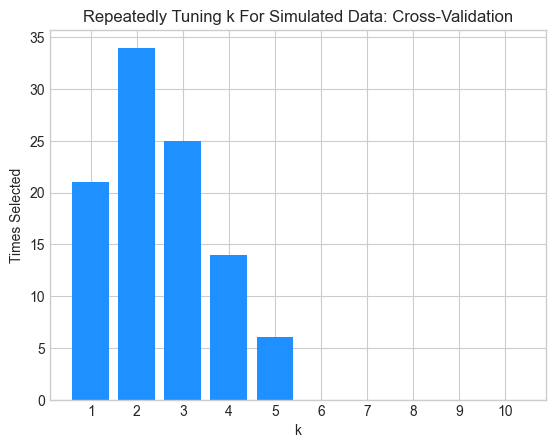

In [22]:
fig, ax = plt.subplots()

ax.bar(k_values, [k_best.count(i) for i in k_values], color="dodgerblue")
ax.set_title("Repeatedly Tuning k For Simulated Data: Cross-Validation")
ax.set_xlabel("k")
ax.set_ylabel("Times Selected")

ax.set_xticks(k_values)

plt.show()

**Takeaway**: By using cross-validation, the hyperparameter tuning process is much more stable. In particular, there is less variance is the selected values of the tuning parameters.